# Audio Processing

In [1]:
import IPython
import librosa
import numpy as np
import matplotlib.pyplot as plt

from librosa import display

## Signal Processing

- What an audio file is? $f(t)$
- Discretizing the continuous signal
- Sampling Rate, number of channels

## Case Study - GTZAN dataset

In [2]:
sampling_rate = 22050

In [3]:
x1, s1 = librosa.load('/home/efernand/data/GTZAN/genres_original/jazz/jazz.00000.wav')
x2, s2 = librosa.load('/home/efernand/data/GTZAN/genres_original/metal/metal.00000.wav')

In [4]:
s1, s2

(22050, 22050)

__Note.__ Here, the audio files in this data set have a sampling frequency of 22 kHz, i.e., 1 second corresponds to 22050 samples in the array. Note that the array contains,

In [5]:
x1.shape

(661794,)

samples. A quick calculation shows that these files are roughly 30 seconds long,

In [6]:
print(x1.shape[0] / s1,
      x2.shape[0] / s2)

30.013333333333332 30.00018140589569


In [7]:
x1 = x1[:int(30 * sampling_rate)]
x2 = x2[:int(30 * sampling_rate)]

print(x1.shape, x2.shape)

(661500,) (661500,)


Text(0.5, 0, 'Time (s)')

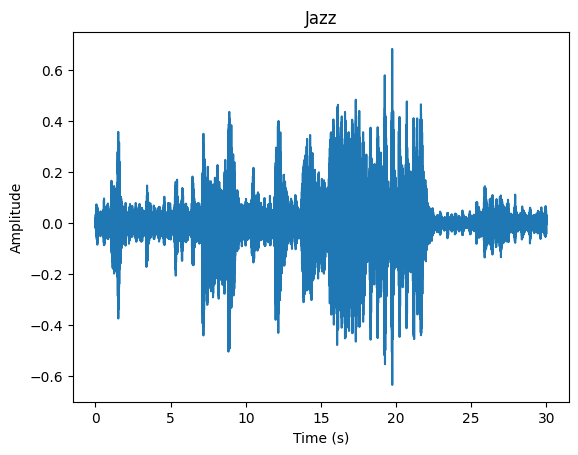

In [8]:
plt.plot(np.linspace(0, x1.shape[0] / s1, x1.shape[0]),
         x1)
plt.title('Jazz')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

In [9]:
IPython.display.Audio(x1, rate=s1)

Text(0.5, 0, 'Time (s)')

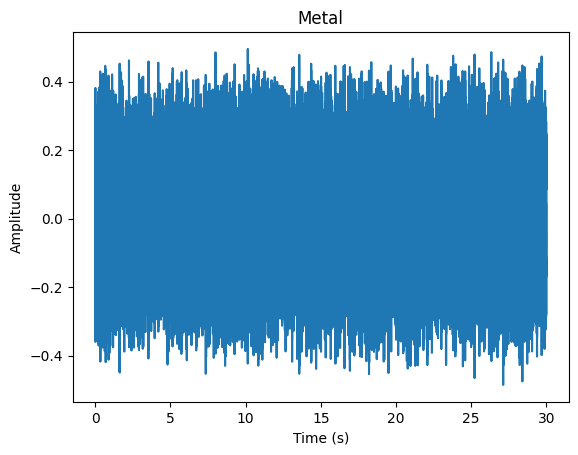

In [10]:
plt.plot(np.linspace(0, x2.shape[0] / s2, x2.shape[0]),
         x2)
plt.title('Metal')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')

In [11]:
IPython.display.Audio(x2, rate=s2)

In [12]:
x2.shape

(661500,)

## Feature Extraction

### Spectograms

__Def.__ A spectrogram is a visual representation of a signal, showing how the spectrum of frequencies changes over time.

#### Short Time Fourier Transform (STFT)

Recall that, in lecture 8, we defined the Fourier transform of a signal $x(t)$ as,

$$X(\omega) = \int_{-\infty}^{+\infty}x(t)exp(-2j\pi\omega t)dt$$

as such, for a frequency value $\omega$, the Fourier transform sums over the entire domain of $x(t)$.

In contrast with this idea, the STFT divides the signal $x(t)$ into _short time segments_, and computes the Fourier transform over these smaller segments. This results in a new transform, defined over time-frequency couples, i.e., $X(\omega, t)$. Formally, let $y(\tau)$ be a __window function__, i.e., a function that is zero-valued outside a given interval. The STFT is defined as,

$$X(\omega, t) = \int_{-\infty}^{+\infty}x(s)y(s-t)exp(-2j\pi\omega s)ds$$

In [13]:
n_fft = 2048

win_len_sec = 2.5e-2 # in seconds
win_len = int(win_len_sec * sampling_rate)

hop_len_sec = 1e-2
hop_len = int(hop_len_sec * sampling_rate)

print(n_fft, win_len, hop_len)

2048 551 220


Here, we are discretizing the time and frequency axis. The time axis is divided into $n\_frames = \frac{len(x)}{hop\_len} = \frac{22050}{220} = 3006.82$ segments, i.e.,

In [14]:
x1.shape[0] / hop_len

3006.818181818182

which is rounded to 3007. The frequency axis is divided into $\frac{sr}{2} + 1$, which is equal to the [Nyquist Frequency](https://en.wikipedia.org/wiki/Nyquist_frequency). The window length plays a role into the weighting that is given to the parts of the signal. We can take the STFT using librosa,

In [15]:
X1 = librosa.stft(y=x1, n_fft=n_fft, win_length=win_len, hop_length=hop_len)
X2 = librosa.stft(y=x2, n_fft=n_fft, win_length=win_len, hop_length=hop_len)

Note that, since we divided the frequency range $[0, sr]$ into 2048 bins, each step we take in the y-axis represents $\frac{sr}{n\_\text{fft}} = \frac{22050}{2048} = 10.766 Hz$.

We can repeat the same reasoning to the x-axis. Since $len(x)$ represents 30 seconds, each segment in the STFT will have $\frac{time(x)}{hop\_len} = \frac{30}{220} = 0.136$ seconds.

Overall, the STFT generates an array of shape $(1 + \frac{n\_\text{fft}}{2}, n\_frames)$, that is,

In [16]:
print(X1.shape, X2.shape)

(1025, 3007) (1025, 3007)


In [17]:
sampling_rate / 2

11025.0

Now, we are interested in representing the y-axis and x-axis semantically. We known that the $1025$ positions in the rows represent the range $[0, \frac{sr}{2}] = [0, 11025]$. We then divide the y-axis into $[0, 2000, 4000, \cdots, 10000]$. We then need to find the positions $ind_{i}$ that corresponds to the frequency $f_{i}$, for $i=0,\cdots,5$. We can do so through $f_{i} = i \times \frac{sr}{n\_\text{fft}}$.

We repeat the process for the time axis, in which $t_{i} = \frac{i}{hop\_len\_sec}$.

In [20]:
ylabels = np.array([2000 * i for i in range(6)])
yticks = (ylabels / (sampling_rate / n_fft)).astype(int)

xlabels = np.array([5 * i for i in range(7)]) 
xticks = (xlabels / hop_len_sec).astype(int)

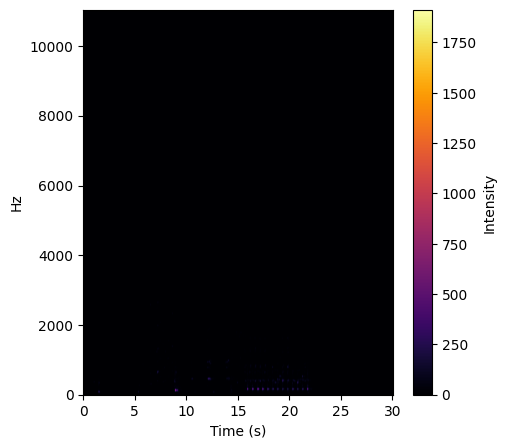

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Shows spectrogram
im = ax.imshow(abs(X1)[::-1, :] ** 2, aspect='auto',
               extent=(0, X1.shape[1], 0, X1.shape[0]),
               cmap='inferno')

# Set axes labels
ax.set_ylabel('Hz')
ax.set_xlabel('Time (s)')

# Set ticks
_ = ax.set_yticks(yticks, ylabels)
_ = ax.set_xticks(xticks, xlabels)

# Set colorbar
cbar = fig.colorbar(im)
cbar.set_label('Intensity')

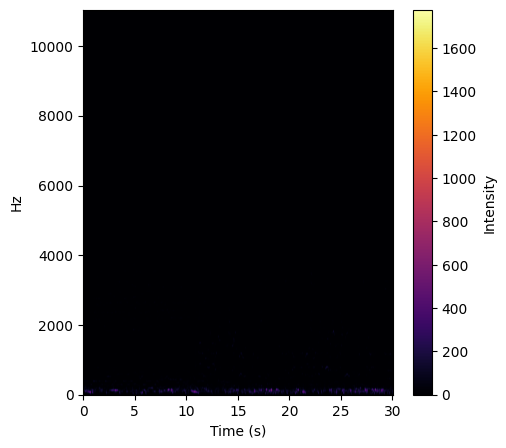

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Shows spectrogram
im = ax.imshow(abs(X2)[::-1, :] ** 2, aspect='auto',
               extent=(0, X2.shape[1], 0, X2.shape[0]),
               cmap='inferno')

# Set axes labels
ax.set_ylabel('Hz')
ax.set_xlabel('Time (s)')

# Set ticks
_ = ax.set_yticks(yticks, ylabels)
_ = ax.set_xticks(xticks, xlabels)

# Set colorbar
cbar = fig.colorbar(im)
cbar.set_label('Intensity')

__Issue.__ Here, we visualized the spectrogram of the signals, but not much is visible. There are two problems with the generated images, w.r.t. how humans perceive frequency and the intensity of the power spectrum.

First, we need to convert the intensity to [decibels](https://en.wikipedia.org/wiki/Decibel) (dB), which is a unit that measures power in a logarithmic scale. With that in mind, we can perceive a bit of difference between the 2 signals,

In [23]:
S1 = abs(X1) ** 2
S2 = abs(X2) ** 2

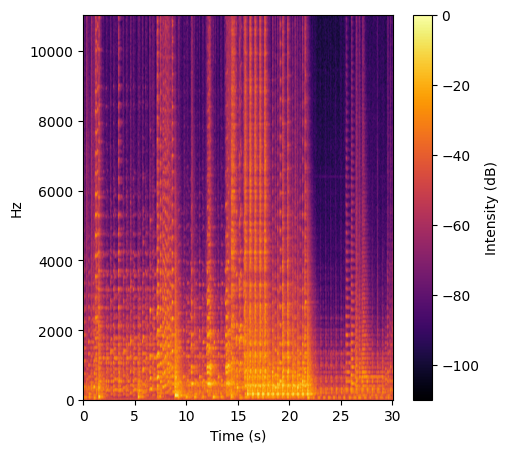

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Shows spectrogram
im = ax.imshow(10 * np.log10(S1[::-1] / S1.max() + 1e-11), aspect='auto',
               extent=(0, X1.shape[1], 0, X1.shape[0]),
               cmap='inferno')

# Set axes labels
ax.set_ylabel('Hz')
ax.set_xlabel('Time (s)')

# Set ticks
_ = ax.set_yticks(yticks, ylabels)
_ = ax.set_xticks(xticks, xlabels)

# Set colorbar
cbar = fig.colorbar(im)
cbar.set_label('Intensity (dB)')

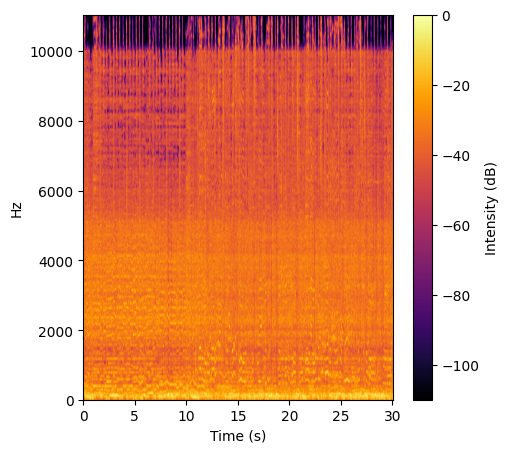

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Shows spectrogram
im = ax.imshow(10 * np.log10((S2[::-1] / S2.max()) + 1e-11), aspect='auto',
               extent=(0, X1.shape[1], 0, X1.shape[0]),
               cmap='inferno')

# Set axes labels
ax.set_ylabel('Hz')
ax.set_xlabel('Time (s)')

# Set ticks
_ = ax.set_yticks(yticks, ylabels)
_ = ax.set_xticks(xticks, xlabels)

# Set colorbar
cbar = fig.colorbar(im)
cbar.set_label('Intensity (dB)')

As it turns out, humans perceive frequency in a logarithmic scale as well. This led to the development of the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale), which is given by,

$$m = 2595\log_{10}\biggr{(} 1 + \frac{f}{700} \biggr{)}$$

where $f$ represents the frequency in Hertz, whereas $m$ represents the Frequency in Mels.

#### Mel Spectrogram

We can compute the Mel Spectrogram directly using [librosa's melspectrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html). The result is a matrix of shape $(n\_mels, n\_frames)$, i.e., each cell $(i, j)$ represent the signal intensity for the $i-th$ __mel bank__, at the $j-th$ window. For instance,

In [26]:
M1 = librosa.feature.melspectrogram(y=x1,
                                    sr=sampling_rate,
                                    n_mels=128,
                                    n_fft=2048,
                                    hop_length=hop_len,
                                    win_length=win_len)

M2 = librosa.feature.melspectrogram(y=x2,
                                    sr=sampling_rate,
                                    n_mels=128,
                                    n_fft=2048,
                                    hop_length=hop_len,
                                    win_length=win_len)

We can easily visualize the spectrogram using [librosa's specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html),

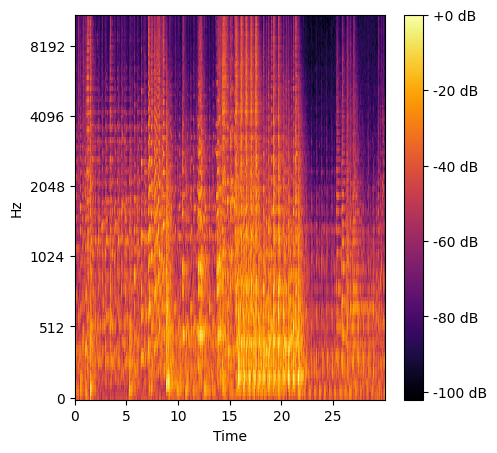

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(10 * np.log10(M1 / M1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='mel',
                         ax=ax,
                         cmap='inferno')
fig.colorbar(im, format='%+2.0f dB')

note that, with the Mel spectrogram, the y-axis (frequency) is displayed in Hertz, but it is logarithmic. We can repeat the process with the second signal,

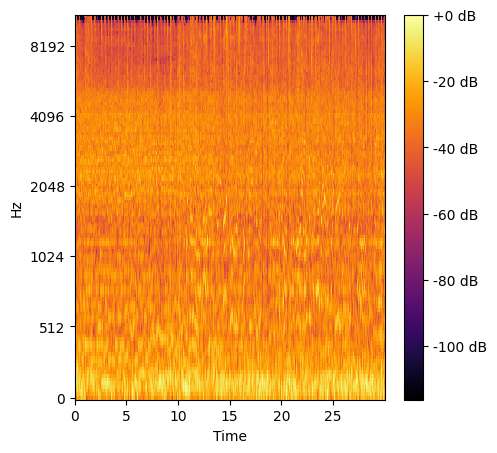

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(10 * np.log10(M2 / M2.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='mel',
                         ax=ax,
                         cmap='inferno')
fig.colorbar(im, format='%+2.0f dB')

__Note.__ The Mel spectrogram discretizes the frequency axis in the same way as the STFT. For instance, we can choose less mel filter banks and produce a smaller image,

In [29]:
M1 = librosa.feature.melspectrogram(y=x1,
                                    sr=sampling_rate,
                                    n_mels=8,
                                    n_fft=2048,
                                    hop_length=hop_len,
                                    win_length=win_len)

M2 = librosa.feature.melspectrogram(y=x2,
                                    sr=sampling_rate,
                                    n_mels=8,
                                    n_fft=2048,
                                    hop_length=hop_len,
                                    win_length=win_len)

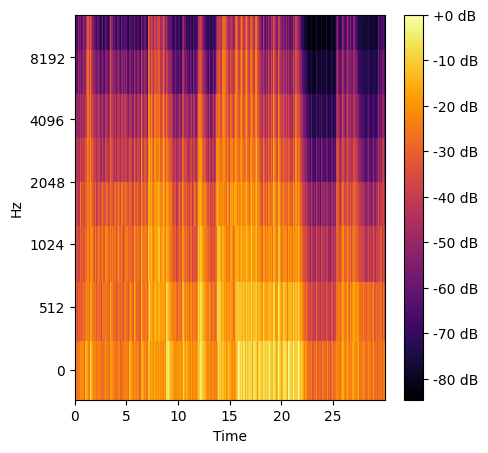

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(10 * np.log10(M1 / M1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='mel',
                         ax=ax,
                         cmap='inferno')
fig.colorbar(im, format='%+2.0f dB')

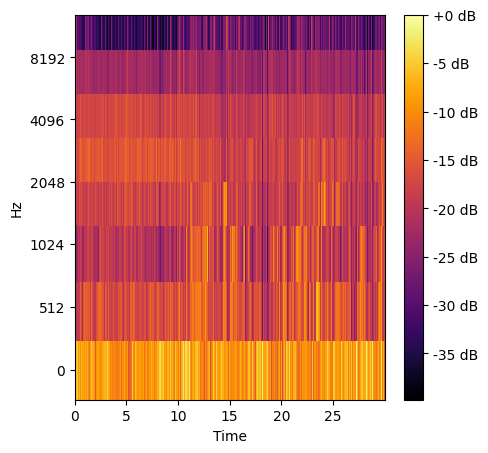

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(10 * np.log10(M2 / M2.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='mel',
                         ax=ax,
                         cmap='inferno')
fig.colorbar(im, format='%+2.0f dB')

compare these plots with those shown earlier to see the discretization artifacts.

From now on, let us focus on the analysis of the paper [Musical Genre Classification of Audio Signals](https://www.cs.cmu.edu/~gtzan/work/pubs/tsap02gtzan.pdf), which characterizes audio files in terms of timbre, rhythm and pitch. Each of these terms is defined as follows,

- __Timbre__ is the perceived sound quality of a musical note. It distinguishes between different instruments in the same category.
- __Pitch__ is a perceptual property of sounds that allows their ordering on a frequency-related scale. It is related to the order in which musical notes are presented.
- __Rhythm__ refers to the periodicity of sounds.

### Characterizing Timbre

#### Mel-frequency Cepstral Coefficients

The [__cepstrum__](https://en.wikipedia.org/wiki/Cepstrum) of a signal corresponds to the __inverse transform of the logarithm of its power spectrum__. Note that the term __cepstrum__ comes from reversing the 4 initial letters of __spectrum__. It serves as a tool for detecting patterns in the frequency spectrum. The cepstral coefficients are derived from the cepstrum. Hence, the mel-frequency cepstral coefficients are values acquired from the signal's mel spectrogram.

In [32]:
mfcc1 = librosa.feature.mfcc(y=x1,
                             sr=sampling_rate,
                             n_mfcc=5,
                             hop_length=hop_len,
                             win_length=win_len)

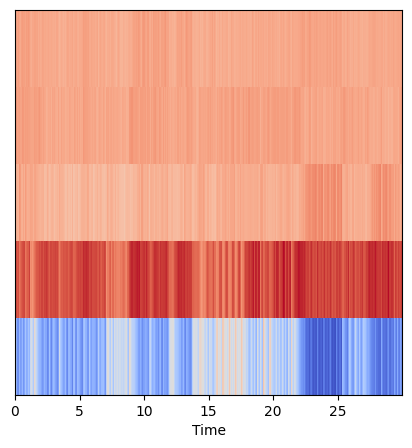

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
img = librosa.display.specshow(mfcc1,
                               sr=sampling_rate,
                               x_axis='time',
                               hop_length=hop_len,
                               ax=ax)

In [34]:
mfcc2 = librosa.feature.mfcc(y=x2,
                             sr=sampling_rate,
                             n_mfcc=5,
                             hop_length=hop_len,
                             win_length=win_len)

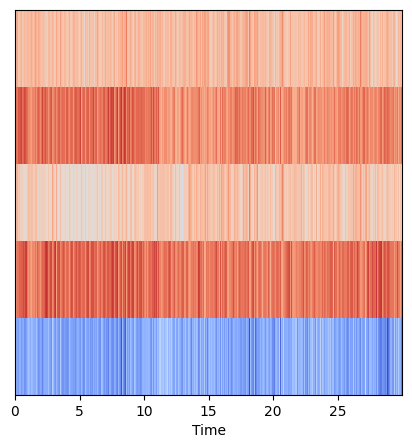

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
img = librosa.display.specshow(mfcc2,
                               sr=sampling_rate,
                               x_axis='time',
                               hop_length=hop_len,
                               ax=ax)

#### Spectral Centroid

The spectral centroid slices the STFT over temporal frames. Let the STFT be denoted by $S \in \mathbb{R}^{n_{\text{fft}} \times n_{\text{frames}}}$. On each frame $t$, it treats the corresponding intensities over frequency $S[:, t]$ as a distribution, i.e., $\tilde{S}[f, t] = \frac{S[f, t]}{\sum_{f}S[f,t]}$. After creating $\tilde{S}$, the spectral centroid $\bar{S}[t]$ is defined as the expected frequency under $\tilde{S}$, i.e.,

$$\bar{S}[t] = \sum_{f}\tilde{S}[f,t]f$$

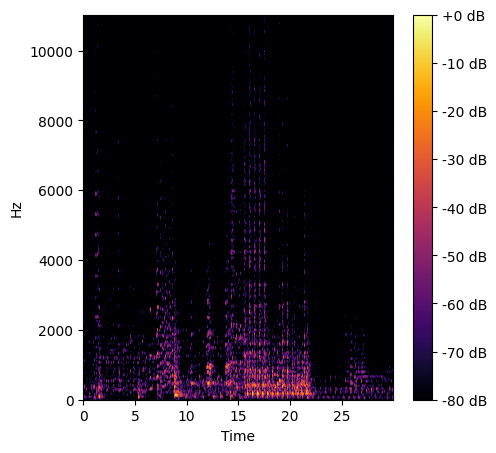

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(librosa.amplitude_to_db(S1, ref=S1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='hz',
                         ax=ax,
                         cmap='inferno')
fig.colorbar(im, format='%+2.0f dB')

In [37]:
spc1 = librosa.feature.spectral_centroid(y=x1,
                                         sr=sampling_rate,
                                         n_fft=n_fft,
                                         hop_length=hop_len,
                                         win_length=win_len).squeeze()

In [38]:
times = np.arange(0, 30, 1 / sampling_rate)[::hop_len]

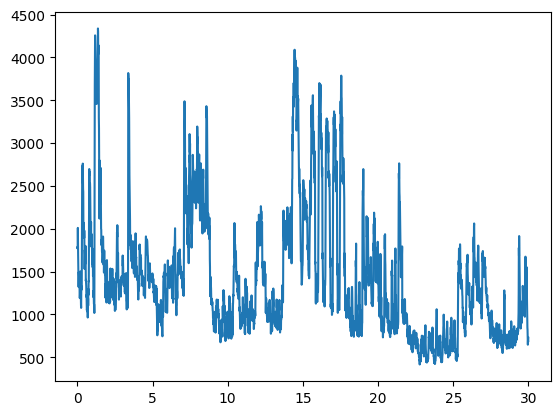

In [39]:
plt.plot(times, spc1)

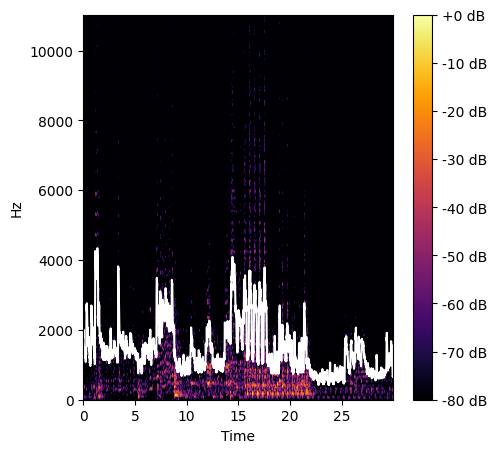

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(librosa.amplitude_to_db(S1, ref=S1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='hz',
                         ax=ax,
                         cmap='inferno')
ax.plot(times, spc1, 'w-')
fig.colorbar(im, format='%+2.0f dB')

#### Spectral Rolloff

Under the same idea, the roll-off frequency $f^{\star}$ is defined as the frequency $f$ for which $P$ per cent of the energy of the spectrum in this frame is contained in this bin or the bins below.

In [262]:
rolloff_sup1 = librosa.feature.spectral_rolloff(y=x1,
                                        sr=sampling_rate,
                                        n_fft=n_fft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        roll_percent=0.99).squeeze()

rolloff_inf1 = librosa.feature.spectral_rolloff(y=x1,
                                        sr=sampling_rate,
                                        n_fft=n_fft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        roll_percent=0.01).squeeze()

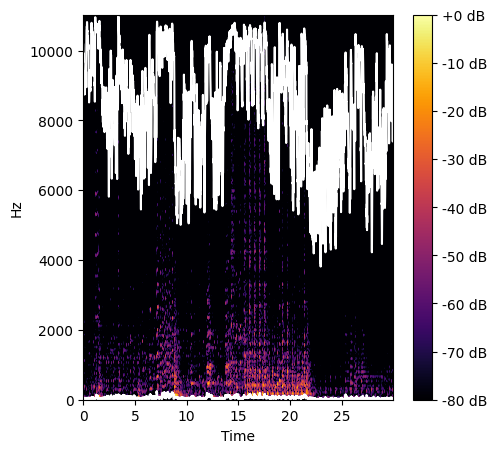

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(librosa.amplitude_to_db(S1, ref=S1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='hz',
                         ax=ax,
                         cmap='inferno')
ax.plot(times, rolloff_sup1, 'w-')
ax.plot(times, rolloff_inf1, 'w-')
fig.colorbar(im, format='%+2.0f dB')

In [266]:
rolloff_cen1 = librosa.feature.spectral_rolloff(y=x1,
                                        sr=sampling_rate,
                                        n_fft=n_fft,
                                        hop_length=hop_len,
                                        win_length=win_len,
                                        roll_percent=0.5).squeeze()

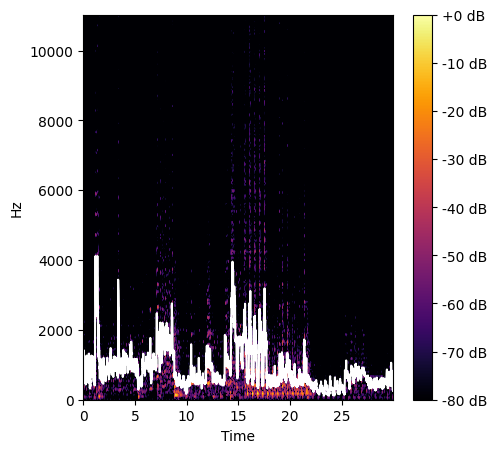

In [267]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im = librosa.display.specshow(librosa.amplitude_to_db(S1, ref=S1.max()),
                         sr=sampling_rate,
                         hop_length=hop_len,
                         x_axis='time',
                         y_axis='hz',
                         ax=ax,
                         cmap='inferno')
ax.plot(times, rolloff_cen1, 'w-')
fig.colorbar(im, format='%+2.0f dB')

__Note.__ While the Spectral centroid is associated with the mean, the spectral rollof with $P = 50\%$ is associated with the median. You can see that they are very similar.

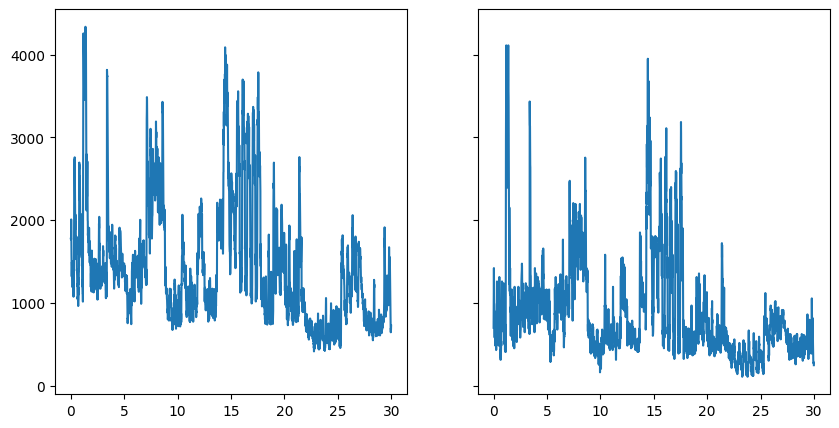

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].plot(times, spc1)
axes[1].plot(times, rolloff_cen1)

#### Zero-Crossing Rate

The Zero Crossing Rate (ZCR) defines the rate in which a signal changes its sign. For a time window composed of $n$ time steps, it is defined as,

$$zcr = \dfrac{1}{n}\sum_{t=1}^{n}|sign(x_{t}) - sign(x_{t-1})|$$

where

$$sign(x) = \begin{cases}
1 & \text{ if } x \geq 0\\
0 & \text{ if } x < 0
\end{cases}$$

In [278]:
zcr1 = librosa.feature.zero_crossing_rate(x1, frame_length=win_len, hop_length=hop_len).squeeze()

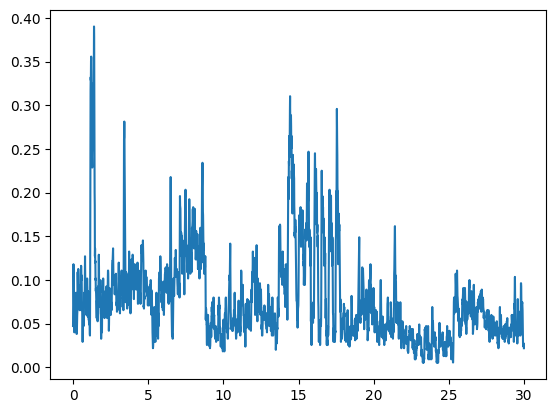

In [280]:
plt.plot(times, zcr1)

### Characterizing Rythm

#### Tempo and Beat detection

__Tempo__, or beats per minute (BPM) is the speed or pace of a given composition. This concept is closely related to rhythm. In this lecture we are going to use two kinds of measures of tempo. First, we are going to use [```librosa.beat.beat_track```](https://librosa.org/doc/latest/generated/librosa.beat.beat_track.html) to estimate the global tempo of a song. [This function uses dynamic programming to track the song beats](http://labrosa.ee.columbia.edu/projects/beattrack/). Then, we're going to analyze audio files using [Tempograms](https://resources.mpi-inf.mpg.de/MIR/tempogramtoolbox/2010_GroscheMuellerKurth_TempogramCyclic_ICASSP.pdf), which count the BPM for time frames. This yeilds an image that is conceptually similar to the short-time Fourier transform.

In [294]:
tempo1, beat1 = librosa.beat.beat_track(y=x1, sr=sampling_rate, hop_length=hop_len, units='time')

In [296]:
beat1

array([ 0.55873016,  1.04761905,  1.50657596,  2.0154195 ,  2.48435374,
        2.95328798,  3.4122449 ,  3.89115646,  4.37006803,  4.84897959,
        5.28798186,  5.74693878,  6.22585034,  6.71473923,  7.12380952,
        7.69251701,  8.22131519,  8.85986395,  9.39863946,  9.93741497,
       10.42630385, 10.97505669, 11.5138322 , 11.97278912, 12.41179138,
       12.86077098, 13.30975057, 13.77868481, 14.28752834, 14.67664399,
       15.07573696, 15.57460317, 16.08344671, 16.5723356 , 17.04126984,
       17.50022676, 17.8893424 , 18.27845805, 18.76734694, 19.23628118,
       19.72517007, 20.20408163, 20.6829932 , 21.16190476, 21.65079365,
       22.07981859, 22.50884354, 22.93786848, 23.41678005, 23.91564626,
       24.39455782, 24.89342404, 25.35238095, 25.89115646, 26.38004535,
       26.95873016, 27.4276644 , 27.91655329, 28.40544218, 28.88435374])

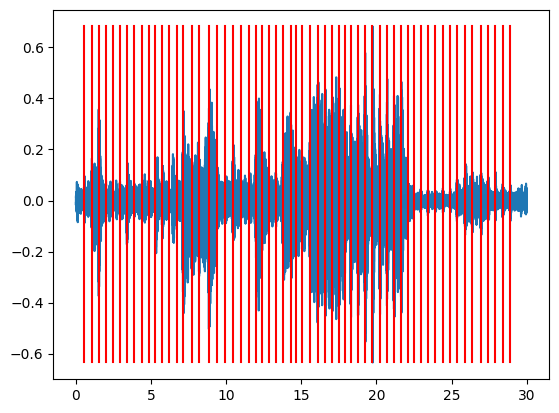

In [299]:
plt.plot(np.arange(0, 30, 1 / sampling_rate), x1)
for b in beat1:
    plt.plot([b, b], [x1.min(), x1.max()], c='r')

the construction of the tempogram is beyond the scope of this lecture. The rough idea consists on calculating the correlation between windows of a given signal. The tempogram is then a matrix $\mathcal{T}(t, \tau)$ for time $t$, and tempo value $\tau$ (in BPM).

In [45]:
tgram1 = librosa.feature.tempogram(y=x1, sr=sampling_rate, hop_length=hop_len, win_length=win_len)
tgram2 = librosa.feature.tempogram(y=x2, sr=sampling_rate, hop_length=hop_len, win_length=win_len)

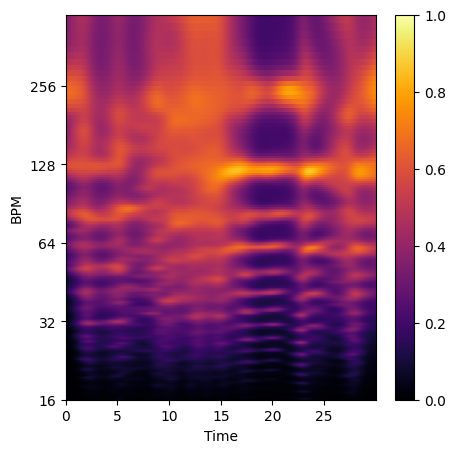

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = librosa.display.specshow(tgram1, sr=sampling_rate, hop_length=hop_len,
                         x_axis='time', y_axis='tempo', cmap='inferno', ax=ax)
fig.colorbar(im)

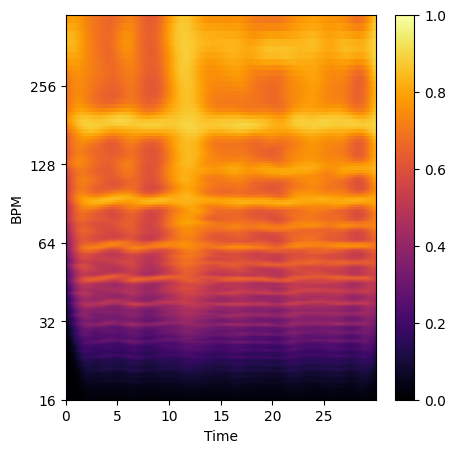

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
im = librosa.display.specshow(tgram2, sr=sampling_rate, hop_length=hop_len,
                         x_axis='time', y_axis='tempo', cmap='inferno', ax=ax)
fig.colorbar(im)

### Characterizing Pitch

Finally, for characterizing pitch, we are going to use a chromagram. Similarly to a spectrogram and a tempogram, the chromagram is a matrix $\mathcal{C}(t, c)$, where $t$ is the time and $c$ is the related [__pitch class__](https://en.wikipedia.org/wiki/Harmonic_pitch_class_profiles) (e.g. C-Major). To extract the chromagram we use [```librosa.feature.chroma_stft```](https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html), which constructs the chromagram. 

In [55]:
chroma1 = librosa.feature.chroma_stft(y=x1,
                                      sr=sampling_rate,
                                      n_fft=n_fft,
                                      hop_length=hop_len,
                                      win_length=win_len)

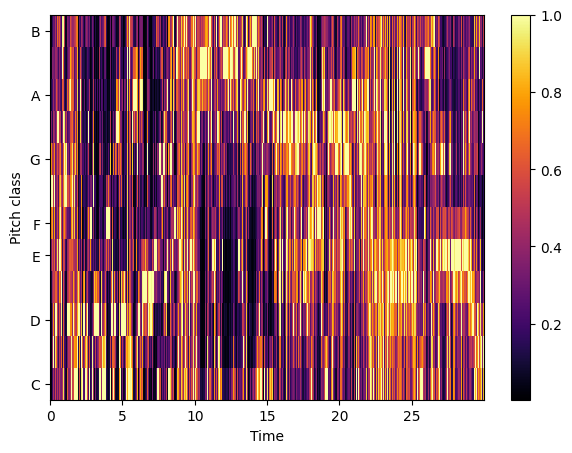

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = librosa.display.specshow(chroma1,
                              y_axis='chroma',
                              x_axis='time',
                              cmap='inferno',
                              hop_length=hop_len,
                              win_length=win_len,
                              ax=ax)
fig.colorbar(im)

In [57]:
chroma2 = librosa.feature.chroma_stft(y=x2,
                                      sr=sampling_rate,
                                      n_fft=n_fft,
                                      hop_length=hop_len,
                                      win_length=win_len)

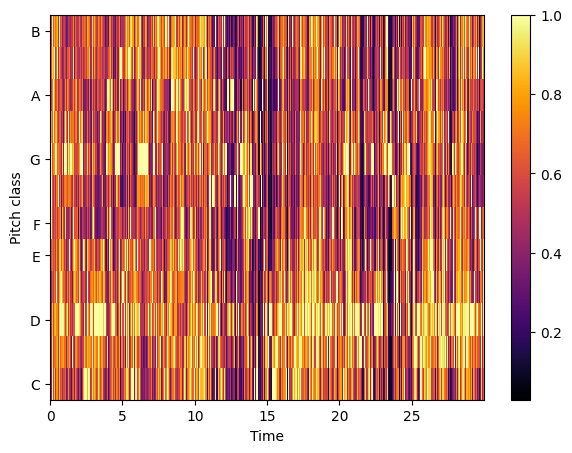

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = librosa.display.specshow(chroma2,
                              y_axis='chroma',
                              x_axis='time',
                              cmap='inferno',
                              hop_length=hop_len,
                              win_length=win_len,
                              ax=ax)
fig.colorbar(im)